# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

Rough outline
## 0. Data preparation
## 1. From musical score to metrical weights
## 2. From metrical weights to periodicities
## 3. From periodicities to time signature
## 4. Accuracy of classification

#TODO:
- consider grace notes as normal notes (replace 'duration' with 'nominal_duration',
because 'duration' is empty for them) -> check before/after impact to classification
- we also need to sum up durations of tied notes based on piece and staff and voice
- use appropriate method to extract frequencies/periodicities
- use appropriate method to infer time signature
- create simple classification accuracy measure with Ground Truth

In [166]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal import find_peaks, get_window
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

## 0. Data preparation

In [286]:
# This is the time unit of 'global_onset' used in the dataset
time_unit = 1/4

meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
df = meter_dataset[['piece','timesig','global_onset', 'staff', 'voice', 'duration', 'nominal_duration', 'tied', 'gracenote']]

# Ignore gracenotes for now
df = df[df['gracenote'].isna()]

timesignatures = [fractions.Fraction(timesig) for timesig in df['timesig']]
max_bar_length = max(timesignatures)

In [287]:
%%time

tied_df = df.sort_values(by=['piece','staff','voice','global_onset']).reset_index()

# Aggregating ties (to verify if this is worse or better)
blocks = (tied_df.tied.ne(tied_df.tied.shift()) & tied_df.tied.ne(tied_df.tied.shift() - 2) & tied_df.tied.ne(tied_df.tied.shift() - 1)).cumsum()
tied_df = tied_df.groupby(blocks, as_index=False).agg({'piece':'first','staff':'first', 'voice':'first', 'timesig':'first', 'global_onset':'first', 'tied':'first', 'duration':'sum'})
old_df = df

# not optimized
# tied_df = pd.DataFrame(columns=['piece', 'staff', 'voice', 'global_onset', 'duration', 'tied', 'timesig'])
# for index, row in wdf.iterrows():
#     if pd.isnull(row['tied']):
#         tied_df.loc[index]=row
#     if row['tied'] == 1:
#         tied_df.loc[index]=row
#         subindex = index
#         while wdf.loc[subindex + 1]['tied'].item() == 0:
#             tied_df.loc[index]['duration'] += wdf.loc[subindex + 1]['duration']
#             subindex += 1
#         else:
#             tied_df.loc[index]['duration'] += wdf.loc[subindex + 1]['duration']


CPU times: user 2.56 s, sys: 117 ms, total: 2.68 s
Wall time: 3.05 s


,piece,staff,voice,timesig,global_onset,tied,duration
0,K279-1,1,1,4/4,0,NaN,1/4
1,K279-1,1,1,4/4,0,NaN,1/4
2,K279-1,1,1,4/4,0,NaN,1/4
3,K279-1,1,1,4/4,3/2,NaN,1/16
4,K279-1,1,1,4/4,7/4,NaN,1/16
...,...,...,...,...,...,...,...
330478,n16op135_04,4,1,4/4,1140,NaN,1/4
330479,n16op135_04,4,1,4/4,1141,NaN,1/4
330480,n16op135_04,4,1,4/4,1142,NaN,1/2
330481,n16op135_04,4,1,4/4,1144,NaN,1/2


In [279]:
df = tied_df
# df = old_df

## 1. From musical score to metrical weights

Smallest note length in dataset: 1/32


,piece,staff,voice,timesig,global_onset,tied,duration
28794,K309-1,1,1,4/4,0,NaN,1/2
28795,K309-1,1,1,4/4,2,NaN,1/2
28796,K309-1,1,1,4/4,4,NaN,3/8
28797,K309-1,1,1,4/4,11/2,NaN,1/16
28798,K309-1,1,1,4/4,23/4,NaN,1/16
...,...,...,...,...,...,...,...
29790,K309-1,1,1,4/4,618,NaN,1/4
29791,K309-1,1,2,4/4,200,NaN,1/8
29792,K309-1,1,2,4/4,401/2,NaN,1/8
29793,K309-1,1,2,4/4,576,NaN,1/8


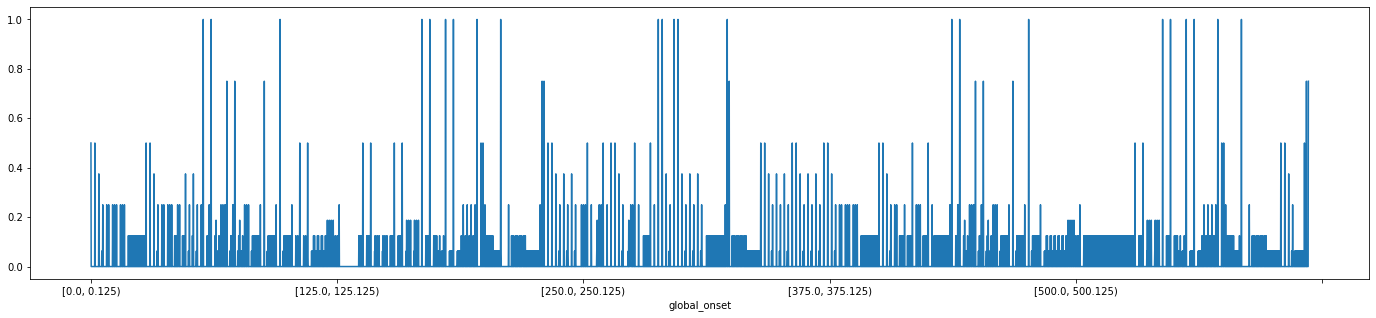

In [280]:
# Select one piece and staff (time signature may change per staff)
one_piece_staff = df[(df['piece'] == 'K309-1') & (df['staff'] == 1)]

# To fine-tune sampling, get minimum note duration among all notes in the piece/staff
min_note = float(one_piece_staff['duration'].min())
print("Smallest note length in dataset:", fractions.Fraction(min_note))

sampling_period = min_note/time_unit
total_piece_duration = one_piece_staff['global_onset'].max()

# Partition the global_onsets in bins
bins = np.arange(0, (total_piece_duration+sampling_period+1e-10), sampling_period)
binned_onsets = pd.cut(one_piece_staff['global_onset'], bins, right = False)

# Compute the sum of durations of all events with onsets in each bin
summed_durations = one_piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)
summed_durations.plot(figsize=(24,5));

one_piece_staff

In [281]:
%%time

# For all pieces and staves (This operation takes around 2-3 minutes on our computer)

# Create dictionaries of total piece durations and smallest notes in each piece/staff
total_piece_durations_df = df.groupby(['piece','staff'])['global_onset'].max().apply(float)
minimum_note_durations_df = df.groupby(['piece','staff'])['duration'].min().apply(float)
total_piece_durations = total_piece_durations_df.to_dict()
minimum_note_durations = minimum_note_durations_df.to_dict()

summed_durations = {}
for key,value in total_piece_durations.items():
    piece_staff = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

    min_note = minimum_note_durations[key]
    sampling_period = min_note/time_unit

    bins = np.arange(0, (value+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_staff['global_onset'], bins, right = False)
    summed_durations[key] = piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 1min 50s, sys: 1.78 s, total: 1min 51s
Wall time: 2min 2s


Metrical weights of Piece: n12op127_04, Staff: 1, Time Signature: 2/2


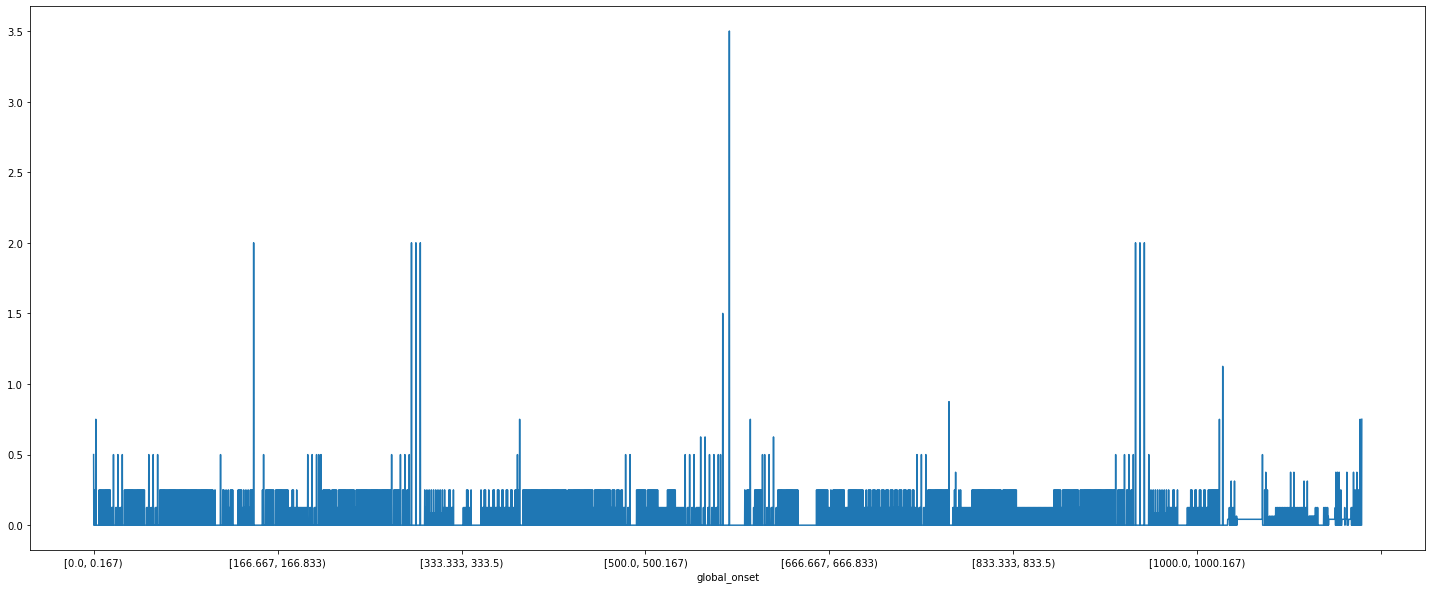

In [282]:
# Now we can plot the metrical weights of a random piece + staff
random_piece_staff = df[['piece', 'staff']].sample(n=1).to_records(index=False)
key = tuple(random_piece_staff[0])

# Get timesignature for reference
timesig = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]['timesig'].sample(n=1).item()

print("Metrical weights of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

# Plot metrical weights
summed_durations[key].plot(figsize=(25,10));


## 2. From metrical weights to periodicities

Periodicity analysis of Piece: n12op127_04, Staff: 1, Time Signature: 2/2


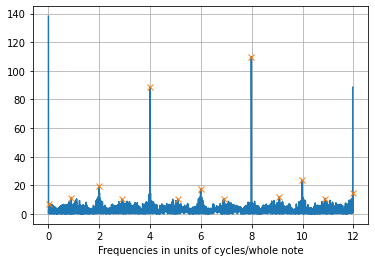

    frequency (cycles/whole note) period (1/f)   amplitude
8                        7.982874          1/8  109.799246
4                        3.991437          1/4   88.438075
10                       9.980329         1/10   23.573892
2                        1.997455          1/2   19.288238
6                        5.988892          1/6   17.640007
12                      11.970837         1/12   14.839881
9                        9.080606       11/100   11.801665
1                        0.899723         10/9   11.379094
11                      10.869631         8/87   10.769557
7                        6.919880        13/90   10.484790
3                        2.897179        29/84   10.352324
5                        5.099591        10/51   10.278168
0                        0.024317      3989/97    7.251286


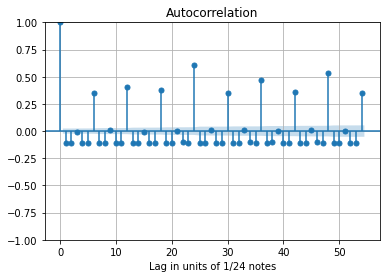

   lag (whole notes)  autocorrelation
24                 1         0.608817
48                 2         0.534289
36            149/99         0.469566
12               1/2         0.401859
18             73/97         0.380963
42            128/73         0.362837
6                1/4         0.354181
54            124/55         0.351201
30            124/99         0.347622
9              35/93         0.012200
45             62/33         0.011297
27             62/55         0.009848
33             62/45         0.007279
21             64/73         0.001349
51            181/85         0.001134


In [283]:
print("Periodicity analysis of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

x = summed_durations[key].index.tolist()
y = summed_durations[key].tolist()

# Number of sample points
N = len(x)
# Sample spacing (in units of time_unit)
T = x[1].left

################################################################
# Window the signal to reduce spectral leakage in the FFT (a good practise)
window = get_window('hann', N)

# Compute Fourier transform of signal
yf = rfft(y * window)
xf = rfftfreq(N, T)
# Convert frequencies to units of cycles/whole note
xf = xf/time_unit
# Convert Fourier output to real-valued amplitudes
amplitudes = np.abs(yf)

# Find significant peaks (using min distance between neighbouring peaks)
peaks, _ = find_peaks(amplitudes, distance=N*.07)

##### Plot Right Fast Fourier Transform #####
plt.plot(xf, amplitudes)
plt.plot(xf[peaks], amplitudes[peaks], "x")
plt.xlabel('Frequencies in units of cycles/whole note')
plt.grid()
plt.show()

##### Get top frequencies (and periods) #####
fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
# Create DataFrame
fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency (cycles/whole note)', 'period (1/f)', 'amplitude'])
# Convert period (1/f) to Fractions
fourier_df['period (1/f)'] = [fractions.Fraction(period).limit_denominator(100) for period in fourier_df['period (1/f)']]
# Sort in descending order
fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False)
print(fourier_df_sorted)

################################################################
# Create a window with the first few lags
# The window length will correspond to the maximum bar length (time signature) found in the dataset in the units of whole notes
nlags = math.ceil(max_bar_length / (T*time_unit))

##### Plot autocorrelations with respect to first few lags #####
plot_acf(y, lags=nlags)
plt.xlabel('Lag in units of {} notes'.format(fractions.Fraction(T*time_unit).limit_denominator(100)))
plt.grid()
plt.show()

##### Get top autocorrelations #####
autocorr = sm.tsa.acf(y, nlags=nlags)
# Convert lags in units of whole notes
converted_lags = range(len(autocorr)) * (T*time_unit)
# Create DataFrame
autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
# Convert lags to Fractions
autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
# Sort in descending order
autocorr_df_sorted = autocorr_df.sort_values(ascending=False, by='autocorrelation').where(autocorr_df.autocorrelation > 0).dropna().drop(0)
print(autocorr_df_sorted)

